In [1]:
import praw
import numpy as np
import pandas as pd

In [2]:
reddit = praw.Reddit(client_id='Wa_QQy6c8J6w_Q',
                     client_secret='i7XCwT6iYlE4O1wLqjJCfDRsFV0',
                     user_agent='diggity_diggity_doge')

In [3]:
common_words = ["http","https","com","www","imgur","r","a","about","all","are","an","also","and","as","at","be","because","but","by","can","come","could","day","do","deleted","even","find","first","for","from","get","give","go","have","he","her","here","him","has","his","how","i","is","if","in","into","it","its","it's","i'm","just","know","like","look","make","man","many","me","more","my","new","no","not","now","of","on","one","only","or","other","our","out","people","say","see","she","so","some","take","tell","than","that","the","their","them","then","there","these","they","thing","think","this","those","time","to","two","up","use","very","want","was","way","we","were","well","what","when","which","who","will","with","would","year","you","your"]
texts = []
labels = []

In [6]:
def get_comments(subreddit, number, label):
    for submission in reddit.subreddit(subreddit).top('year', limit=number):
        submission.comment_sort = 'top'
        submission.comments.replace_more(limit=0)
        for top_level_comment in submission.comments:
            texts.append(parse_comment(top_level_comment.body))
            labels.append(label)
            
def parse_comment(comment):
        comment_arr = []
        new_comment = comment.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
        for word in new_comment.split():
            if word.lower() not in common_words:
                comment_arr.append(word.lower())
        return " ".join(comment_arr)

In [7]:
right = ['The_Donald', 'conservative', 'republican']
left = ['esist', 'FuckTheAltRight', 'liberal']

for sub in right:
    get_comments(sub, 120, 0)
    print('Done with', sub)
    
for sub in left:
    get_comments(sub, 120, 1)
    print('Done with', sub)

Done with The_Donald
Done with conservative
Done with republican
Done with esist
Done with FuckTheAltRight
Done with liberal


In [8]:
print(len(texts))

52688


In [ ]:
df = pd.DataFrame(texts)

In [ ]:
df.info()

In [ ]:
df.head(10)

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = 45000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:]
y_val = labels[training_samples:]

Using TensorFlow backend.


Found 40862 unique tokens.
Shape of data tensor: (52688, 100)
Shape of label tensor: (52688,)


In [10]:
x_val.shape

(7688, 100)

In [20]:
sequences[4]

[954, 2238, 8256, 17, 45]

In [21]:
texts[4]

"tonight celebrate tomorrow's fucking maga"

In [ ]:
word_index

In [ ]:
#make charts showing the most common words in each subreddit
#you can do this by making lists for each subreddit then using
#the tokenizer
#you can then go back and make a dictionary (or something) with 
#the word as key and value as number of occurrances
#loop through all the text and you'll get the number of occurances
#graph that

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SimpleRNN

max_features = 10000
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 45000 samples, validate on 7688 samples
Epoch 1/5
45000/45000 [==============================] - 217s 5ms/step - loss: 0.5731 - acc: 0.7019 - val_loss: 0.5398 - val_acc: 0.7318
Epoch 2/5
45000/45000 [==============================] - 209s 5ms/step - loss: 0.5028 - acc: 0.7535 - val_loss: 0.5203 - val_acc: 0.7383
Epoch 3/5
45000/45000 [==============================] - 216s 5ms/step - loss: 0.4772 - acc: 0.7716 - val_loss: 0.5304 - val_acc: 0.7456
Epoch 4/5
45000/45000 [==============================] - 207s 5ms/step - loss: 0.4587 - acc: 0.7825 - val_loss: 0.5343 - val_acc: 0.7395
Epoch 5/5
45000/45000 [==============================] - 201s 4ms/step - loss: 0.4436 - acc: 0.7910 - val_loss: 0.5187 - val_acc: 0.7449


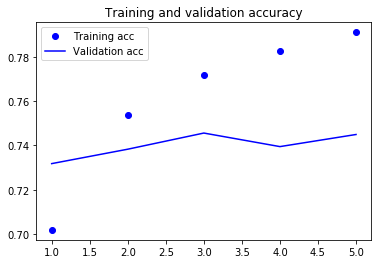

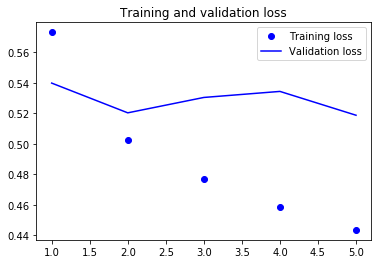

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
rounded_predictions = model.predict_classes(x_val, batch_size=10, verbose=0)

In [15]:
rounded_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_val, rounded_predictions)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[4212  862]
 [1099 1515]]


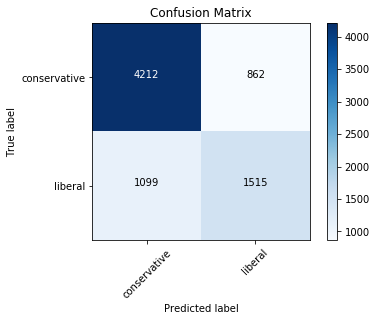

In [19]:
cm_plot_labels = ['conservative', 'liberal']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')